# Convolutional Neural Networks

Implantation of CNN using PyTorch Tutorial for Image classification.
1. Load and normalize any dataset available in PyTorch
2. Design LeNet model using PyTorch.
3. Train and Test the model on the selected dataset
4. Experiment with different number of filters, kernel sizes, number of layers.
5. Compare the results.

Reference: [Pytorch Datasets](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)

----

Lets build a simple convolutional neural network using Pytorch and train it to recognize handwritten digits available on `MNIST` database.

In [5]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from time import time


## 1. Loading and normalizing dataset from pytorch
Lets download the training and testing datasets from torch of `MNIST`.

In [6]:
root_dir = ""


training_data = datasets.MNIST(
	root = root_dir,
	train = True,
	download = True,
	transform = transforms.ToTensor()
)

test_data = datasets.MNIST(
	root = root_dir,
	train = False,
	download = True,
	transform = transforms.ToTensor()
)

In [7]:
training_data, test_data

(Dataset MNIST
     Number of datapoints: 60000
     Root location: 
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset MNIST
     Number of datapoints: 10000
     Root location: 
     Split: Test
     StandardTransform
 Transform: ToTensor())

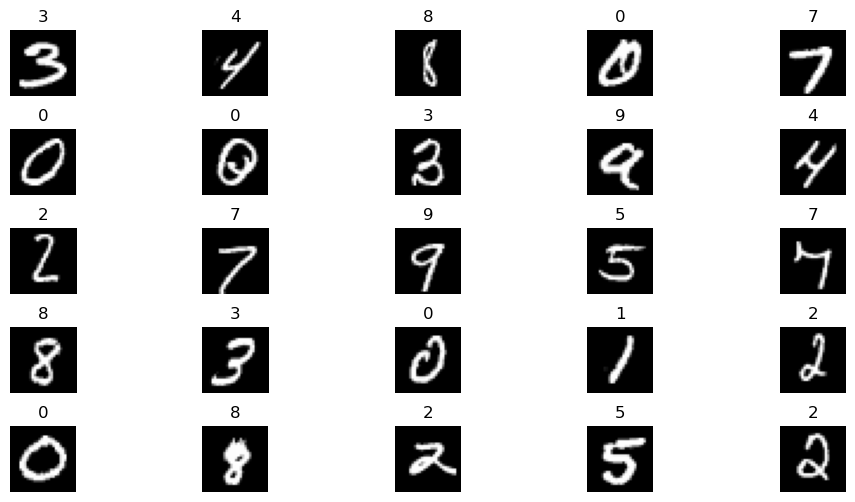

In [8]:
rows, cols = 5, 5
fig, axes = plt.subplots(rows, cols, figsize=(12,6))
for i in range(1, rows*cols + 1):
	sample_idx = torch.randint(len(training_data), size=(1,)).item()
	img, label = training_data[sample_idx]
	plt.subplot(rows, cols, i)
	plt.title(label)
	plt.imshow(img.squeeze(), cmap="gray")
	plt.axis("off")
plt.subplots_adjust(hspace=0.50)
plt.show()

### Preparing our data with DataLoaders

The Dataset retrieves our dataset’s features and labels one sample at a time. While training a model, we typically want to pass samples in “minibatches”, reshuffle the data at every epoch to reduce model overfitting, and use Python’s multiprocessing to speed up data retrieval.

DataLoader is an iterable that abstracts this complexity for us in an easy API.

In [9]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size = 64, shuffle = True)
test_dataloader = DataLoader(test_data, batch_size = 64, shuffle = True)

### Iterating through the data loader

Now since we got the dataloader in batch format we can iter through the loader and get training_features and training_labels according to the number we used for our batch size.

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


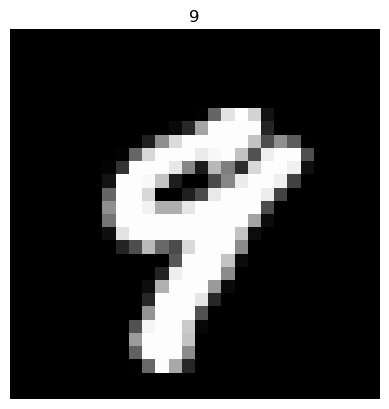

In [10]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

#Lets plot the first image in our first iter
img = train_features[0].squeeze()
label = int(train_labels[0])
plt.imshow(img, cmap="gray")
plt.title(label)
plt.axis("off")
plt.show()


As we got out our dataset lets build the model

## 2. Designing LeNet model using pytorch

In [11]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
	def __init__(self):
		super(Net, self).__init__()
		self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
		self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
		self.conv2_drop = nn.Dropout2d()
		self.fc1 = nn.Linear(20*4*4, 50)
		self.fc2 = nn.Linear(50, 10)
	
	def forward(self, x):
		x = F.relu(F.max_pool2d(self.conv1(x), 2))
		x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
		x = x.view(-1, 20*4*4)
		x = F.relu(self.fc1(x))
		x = self.fc2(x)
		return x

net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.02, momentum=0.8)

## 3. Training and testing the model

In [12]:
from torch.autograd import Variable

def train_model(epochs, model):
	t0 = time()
	print("Started Training ....")
	for epoch in range(epochs):
		running_loss = 0.0
		correct = 0
		total = 0
		for index, data in enumerate(train_dataloader, 0):
			inputs, labels = data
			inputs, labels = Variable(inputs), Variable(labels)
			optimizer.zero_grad()
			outputs = model(inputs)
			loss = criterion(outputs, labels)
			loss.backward()
			optimizer.step()
			#Statistics
			running_loss += loss.item()
			_, predicted = outputs.max(1)
			total += labels.size(0)
			correct += predicted.eq(labels).sum().item()
			if (index % 300) == 299: # for every 100 mini batches print
					l = running_loss / 300
					a = 100.*(correct/total)
					print(f"Epoch: {epoch + 1}/{epochs}, Batch: {index + 1} => LOSS: {round(l, 5)}, ACCURACY: {round(a, 5)}")
					running_loss = 0.0
	print("Finished Training in %0.3fs"%(time()-t0))

def test_model(model):
	correct = 0
	total = 0
	with torch.no_grad():
			for data in test_dataloader:
					images, labels = data
					outputs = model(images)
					_, predicted = torch.max(outputs.data, 1)
					total += labels.size(0)
					correct += (predicted == labels).sum().item()

	print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

In [13]:
train_model(epochs=3, model=net)
test_model(model=net)

Started Training ....
Epoch: 1/3, Batch: 300 => LOSS: 0.9304, ACCURACY: 69.40104
Epoch: 1/3, Batch: 600 => LOSS: 0.2483, ACCURACY: 81.01042
Epoch: 1/3, Batch: 900 => LOSS: 0.18942, ACCURACY: 85.51215
Epoch: 2/3, Batch: 300 => LOSS: 0.15975, ACCURACY: 95.21354
Epoch: 2/3, Batch: 600 => LOSS: 0.14226, ACCURACY: 95.46615
Epoch: 2/3, Batch: 900 => LOSS: 0.12728, ACCURACY: 95.66667
Epoch: 3/3, Batch: 300 => LOSS: 0.11559, ACCURACY: 96.46354
Epoch: 3/3, Batch: 600 => LOSS: 0.10659, ACCURACY: 96.64844
Epoch: 3/3, Batch: 900 => LOSS: 0.10218, ACCURACY: 96.80903
Finished Training in 28.801s
Accuracy of the network on the 10000 test images: 97 %


## 4. Experimenting with hyperparameters

Lets define another neural network with different number of layers and kernels

In [14]:
class Net2(nn.Module):
	def __init__(self):
		super(Net2, self).__init__()
		self.conv1 = nn.Conv2d(1, 6, kernel_size=7)
		self.conv2 = nn.Conv2d(6, 10, kernel_size=7)
		self.conv2_drop = nn.Dropout2d()
		self.fc1 = nn.Linear(10*2*2, 30)
		self.fc2 = nn.Linear(30, 15)
		self.fc3 = nn.Linear(15, 10)
	
	def forward(self, x):
		x = F.relu(F.max_pool2d(self.conv1(x), 2))
		x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
		x = x.view(-1, 10*2*2)
		x = F.relu(self.fc1(x))
		x = self.fc2(x)
		x = F.elu(self.fc3(x))
		return x

net_2 = Net2()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net_2.parameters(), lr=0.02)

In [15]:
train_model(epochs=2, model=net_2)
test_model(model=net_2)

Started Training ....
Epoch: 1/2, Batch: 300 => LOSS: 1.01879, ACCURACY: 66.13021
Epoch: 1/2, Batch: 600 => LOSS: 0.66032, ACCURACY: 72.875
Epoch: 1/2, Batch: 900 => LOSS: 0.5906, ACCURACY: 75.94965
Epoch: 2/2, Batch: 300 => LOSS: 0.53802, ACCURACY: 84.20833
Epoch: 2/2, Batch: 600 => LOSS: 0.536, ACCURACY: 84.34115
Epoch: 2/2, Batch: 900 => LOSS: 0.5174, ACCURACY: 84.57465
Finished Training in 17.884s
Accuracy of the network on the 10000 test images: 86 %


## 5. Performance comparison

After modifying kernel size to = 7, and number of filters and after adding exponential linear unit with another layer at the end seems to decrease the accuracy of our model.


So lets deploy our first model using `torch.save()`.

In [16]:
torch.save(net.state_dict(), "cnn_state.pt")
torch.save(net, "cnn_model.pt")